# FWI work 1009

Suppose $f = \sum_i f_i \delta_{x_i}$ and $g = \sum_j g_j \delta_{y_j}$. Here we suppose $f_i, g_j \geq 0$ for all $i$ and $j$.
We can define a distance for $f$ and $g$:
$$d(f,g) = (1-\theta)W_2^2\left(\frac{f}{\|f\|_1}, \frac{g}{\|g\|_1}\right) + \theta \left| \|f\|_1 - \|g\|_1 \right| $$

It can be check that $d(f,g)$ is a distance, i.e. non negativity, symmetry, triangle inequality, $d(f,g)=0 \to f=g$.

Since $f,g \in \mathbb{R}^N_+$, $(\mathbb{R}^N_+, d)$ is a metric space.
We should have the usual topology on $\mathbb{R}^N$ and the strong convergence for sequence.

The gradient:
$$D_f W_2^2 \left(\frac{f}{\|f\|_1}, \frac{g}{\|g\|_1}\right) = D_1 W_2^2 \left(\frac{f_+}{\|f_+\|}, \frac{g_+}{\|g_+\|}\right) D_f \left(\frac{f}{\|f\|_1}\right) \\
= D_1 W_2^2 \left(\frac{f}{\|f\|_1}, \frac{g}{\|g\|_1}\right) \left[ -\frac{f}{\|f\|_1^2} \text{sign}(f)' + \frac{1}{\|f\|_1} I_{N\times N}\right]$$

$$D_f \left| \|f\|_1 - \|g\|_1 \right| = \text{sign}( \|f\|_1 - \|g\|_1 ) \text{sign}(f)'$$

In our work, we are using the Sinkhorn approximation of Wasserstein distance. So we replace $W_2^2$ by $S_2^2$ and the gradient $D_1 W_2^2$ by $D_1 S_2^2$.

**Problem:** 
For the Sinkhorn algorithm, it is not stable for certain cases.
When $f$ and $g$ is complex: the support of $f$ and $g$ has gaps, $f$ and $g$ is not continuous enough.
One way might solve the problem is to do a convolution with a smooth kernal.

**For signals:**

There are two ways to normalization $f$ and $g$ such that the distance can be extend to $f,g\in \mathbb{R}^N$.

1. Define linear operator $P_f^+$ and $P_f^-$ to map $f$ to its positive and negative parts:
$$d_s(f,g) = d(P_f^+f,P_g^+ g) + d(P_f^- f, P_g^- g)$$
2. We working on a bounded subset of $\mathbb{R}^N$, i.e. $f, g \in \{f| f\in \mathbb{R}^n, and |f_i| \leq C \}$:
$$d_s(f,g) = d(f+C, g+C).$$

It can be shown the $d_s$ in both ways is still a distance.

**Problem:**
1. For the first case, $P_f^+$ will make the signal has lots of gap, and not smooth. Not stable for Sinkhorn algorithm
2. For the second case, the gradient will concentrate at the large amplitude part.

In [2]:
# using Distributed
# using SharedArrays
# addprocs(11);

In [5]:
@everywhere include("inverse_prob.jl")

## Model

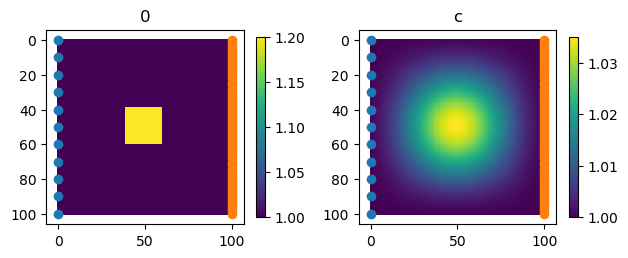

In [6]:
@eval @everywhere begin
Nx = 101;
Ny = 101;
h = 0.01;

Fs = 500;
dt = 1/Fs
Nt = 1001;
t = range(0, length=Nt, step=dt)

source = source_ricker(5, 0.2, t)
# plot(t,source); title("ricker source")
source_position = zeros(11,2)
for i = 1:11
#     source_position[i,:] = [3,(i-1)*10+1]
    source_position[i,:] = [(i-1)*10+1, 1]
end
source = repeat(source, 1, 11)

# receiver_position = zeros(101,2)
# for i = 1:51
# #     receiver_position[i,:] = [1,(i-1)*2+1]
#     receiver_position[i,:] = [1, (i-1)*2+1]
# end
# for i = 52:101
# #     receiver_position[i,:] = [1,(i-1)*2+1]
#     receiver_position[i,:] = [101, (i-51)*2+1]
# end
    
receiver_position = zeros(51,2)
for i = 1:51
#     receiver_position[i,:] = [1,(i-1)*2+1]
    receiver_position[i,:] = [(i-1)*2+1, 101]
end

c = ones(Nx, Ny)
rho = ones(Nx, Ny)

c0 = ones(Nx, Ny)
c00 = ones(Nx, Ny)
rho0 = ones(Nx, Ny)
# c0[25:end,:] .= 1.2;
c0[40:60,40:60] .= 1.2
c00[50:70,50:70] .= 1.2

c = imfilter(c0, Kernel.gaussian(20));
    
pml_len = 10
pml_coef=  100
end

figure; 
subplot(121); imshow(c0); colorbar(shrink=0.4); title("0")
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)
subplot(122); imshow(c); colorbar(shrink=0.4); title("c")
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)
tight_layout()

## Build data

In [7]:
@time data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time data0, u0 = multi_solver_parallel(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

 15.974335 seconds (7.67 M allocations: 384.664 MiB, 2.35% gc time)
  4.063997 seconds (5.72 k allocations: 250.703 KiB)


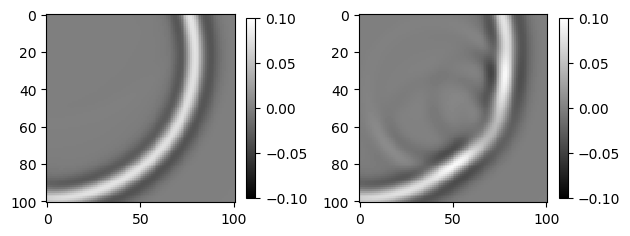

In [8]:
figure;
subplot(121); imshow(u[:,:,500,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
subplot(122);imshow(u0[:,:,500,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
tight_layout()

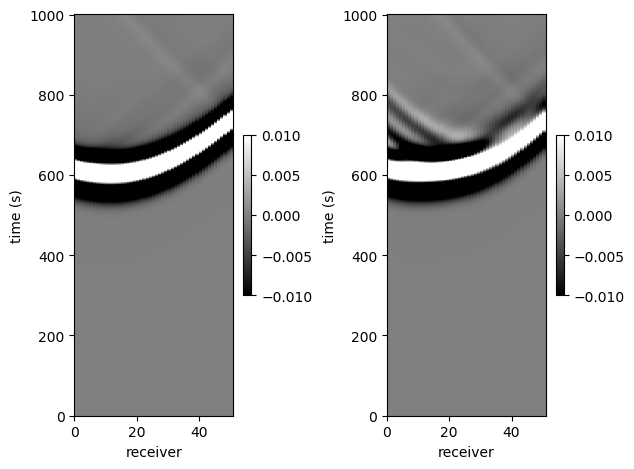

In [9]:
figure;
r_axis = 0:21
subplot(121); pcolor(data[:,:,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
subplot(122); pcolor(data0[:,:,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
tight_layout()

## Adjoint source

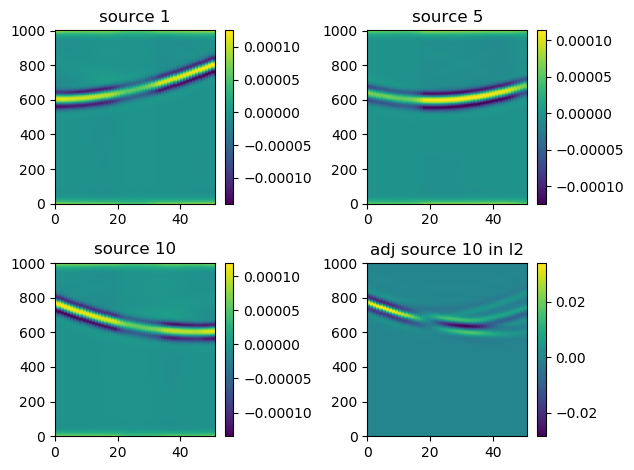

 22.056249 seconds (4.36 M allocations: 221.481 MiB, 0.47% gc time)


In [10]:
M = cost_func_1d(t)
# @time adj, dis = adj_source_sinkhorn_parallel(data, data0, M; theta=0, lambda=1e2, numItermax=1000, stopThr=1e-7, verbose=false);
@time adj, dis = adj_source_sinkhorn_parallel(data, data0, M; theta=0, lambda=1e2, numItermax=100, stopThr=1e-7, verbose=false);

subplot(221); pcolor(adj[:,:,1]); colorbar(); title("source 1")
subplot(222); pcolor(adj[:,:,5]); colorbar(); title("source 5")
subplot(223); pcolor(adj[:,:,10]); colorbar(); title("source 10")
subplot(224); pcolor(data[:,:,10] - data0[:,:,10]); colorbar(); title("adj source 10 in l2")
tight_layout()

In [11]:
# @time gg_sinkhorn, fkk = grad_sinkhorn_parallel(data, u, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position)
# @time gg_l2 = grad_l2_parallel(data, u, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100);
obj_fn_gd(x) = obj_fn_parallel(data0, x, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100)
obj_fn_s(x) = obj_fn_sinkhorn_parallel(data0, x, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100, lambda=1e2, numItermax=10, stopThr = 1e-6)
@time fk_gd, gg_gd = obj_fn_gd(c)
@time fk_s, gg_s = obj_fn_s(c);

 20.108728 seconds (7.82 M allocations: 8.747 GiB, 6.02% gc time)
 30.383142 seconds (943.67 k allocations: 8.420 GiB, 3.10% gc time)


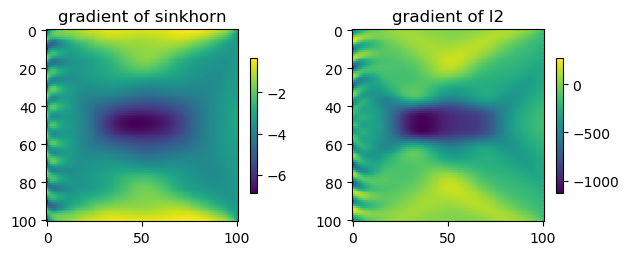

In [12]:
subplot(121); imshow(reshape(gg_s,Nx,Ny)); title("gradient of sinkhorn"); colorbar(shrink=0.3)
subplot(122); imshow(reshape(gg_gd,Nx,Ny)); title("gradient of l2"); colorbar(shrink=0.3)
tight_layout()

## Gradient descent

In [13]:
c_gd, error_gd = gradient_descent_test(obj_fn_gd, c, 1e-3, 10, 1, 1.2; rho=0.8, c=1e-9);

0.2415237813679919
Main iteration: 1
fk: 1.06812e-02 ----------------------------------------------------------------
Main iteration: 2
fk: 1.05211e-02 ----------------------------------------------------------------
Main iteration: 3
fk: 1.03759e-02 ----------------------------------------------------------------
Main iteration: 4
fk: 1.02459e-02 ----------------------------------------------------------------
Main iteration: 5
fk: 1.01366e-02 ----------------------------------------------------------------
Main iteration: 6
fk: 1.00460e-02 ----------------------------------------------------------------
Main iteration: 7
fk: 9.97226e-03 ----------------------------------------------------------------
Main iteration: 8
fk: 9.91370e-03 ----------------------------------------------------------------
Main iteration: 9
fk: 9.86894e-03 ----------------------------------------------------------------
Main iteration: 10
fk: 9.83669e-03 -------------------------------------------------------

In [14]:
c_s, error_s = gradient_descent_test(obj_fn_s, c, 1e-3, 10, 1, 1.2; rho=0.8, c=1e-9);

-0.04681344582671091
Main iteration: 1
fk: 2.68714e+00 ----------------------------------------------------------------
Main iteration: 2
fk: 2.68713e+00 ----------------------------------------------------------------
Main iteration: 3
fk: 2.68713e+00 ----------------------------------------------------------------
Main iteration: 4
fk: 2.68714e+00 ----------------------------------------------------------------
Main iteration: 5
fk: 2.68715e+00 ----------------------------------------------------------------
Main iteration: 6
fk: 2.68717e+00 ----------------------------------------------------------------
Main iteration: 7
fk: 2.68720e+00 ----------------------------------------------------------------
Main iteration: 8
fk: 2.68724e+00 ----------------------------------------------------------------
Main iteration: 9
fk: 2.68728e+00 ----------------------------------------------------------------
Main iteration: 10
fk: 2.68733e+00 -----------------------------------------------------

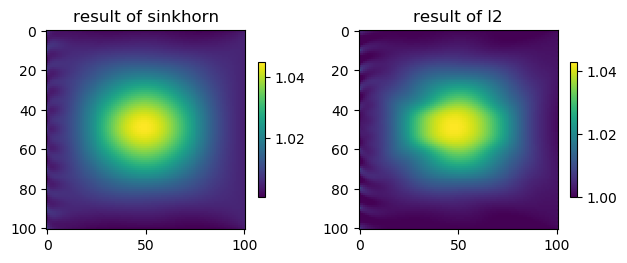

In [21]:
subplot(121); imshow(reshape(c_s,Nx,Ny)); title("result of sinkhorn"); colorbar(shrink=0.3)
subplot(122); imshow(reshape(c_gd,Nx,Ny)); title("result of l2"); colorbar(shrink=0.3)
tight_layout()